## Exploratory Data Analysis (EDA) Notebook
This notebook walks through the key steps of Exploratory Data Analysis (EDA) for the historical IFS dataset. Each step includes a short explanation and can be run directly on the training data.

**Data path:** `data/processed/historical_merged/historical_IFS_merged_201702_to_202504.csv`

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set working directory
os.chdir('C:/Users/jerry/Dropbox/JEREMIAH/MY_STUDIES/DATA_SCIENCE/University_of_Greenwich/Year2/COMP1884 - Group Project/CODE/COMP1884-Group6-Codebase-Complete')

# Load dataset
RAW_DATA_PATH = "data/processed/historical_merged/historical_IFS_merged_201702_to_202504.csv"
df = pd.read_csv(RAW_DATA_PATH, parse_dates=['date'], index_col='date')
df = df.asfreq('h')
df.head()

,temperature_2m,surface_pressure,precipitation,wind_speed_10m
date,,,,
2017-02-01 00:00:00,9.6,1008.2,0.0,14.6
2017-02-01 01:00:00,9.6,1007.4,0.0,14.6
2017-02-01 02:00:00,9.9,1006.8,0.6,15.1
2017-02-01 03:00:00,10.0,1006.5,0.3,15.0
2017-02-01 04:00:00,10.2,1006.2,0.3,15.5


## Step 1: Dataset Overview
Check basic structure, number of rows, columns, data types, and missing values.

In [20]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72264 entries, 2017-02-01 00:00:00 to 2025-04-30 23:00:00
Freq: h
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temperature_2m    72264 non-null  float64
 1   surface_pressure  72264 non-null  float64
 2   precipitation     72264 non-null  float64
 3   wind_speed_10m    72264 non-null  float64
dtypes: float64(4)
memory usage: 2.8 MB


temperature_2m      0
surface_pressure    0
precipitation       0
wind_speed_10m      0
dtype: int64

In [21]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temperature_2m,72264.0,11.295674,6.065065,-8.8,7.0,11.0,15.5,36.9
surface_pressure,72264.0,1011.902779,11.155152,951.1,1005.4,1012.9,1019.5,1046.3
precipitation,72264.0,0.085282,0.342940,0.0,0.0,0.0,0.0,8.9
wind_speed_10m,72264.0,13.399997,7.074155,0.0,7.9,12.3,17.7,61.2


## Step 2: Timestamp Continuity
Ensure that the datetime index has no missing or duplicate entries.

In [22]:
expected_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
missing_times = expected_range.difference(df.index)
print(f'Missing timestamps: {len(missing_times)}')

Missing timestamps: 0


## Step 3: Feature Distributions
Visualise how each variable is distributed.

In [23]:
from scipy.stats import skew

for col in ['temperature_2m', 'surface_pressure', 'precipitation', 'wind_speed_10m']:
    col_skew = skew(df[col])
    print(f'{col}: skew = {col_skew:.2f}')


temperature_2m: skew = 0.19
surface_pressure: skew = -0.53
precipitation: skew = 7.93
wind_speed_10m: skew = 0.82


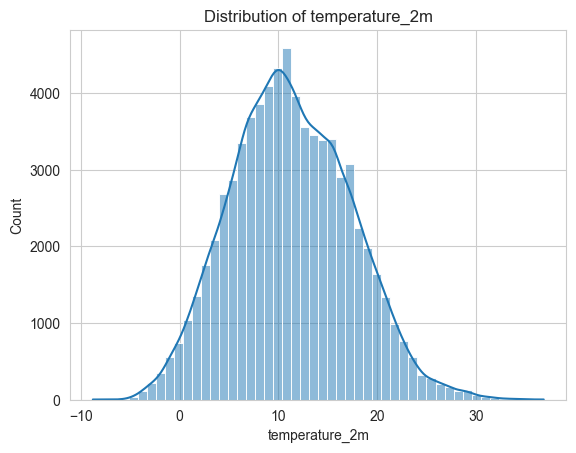

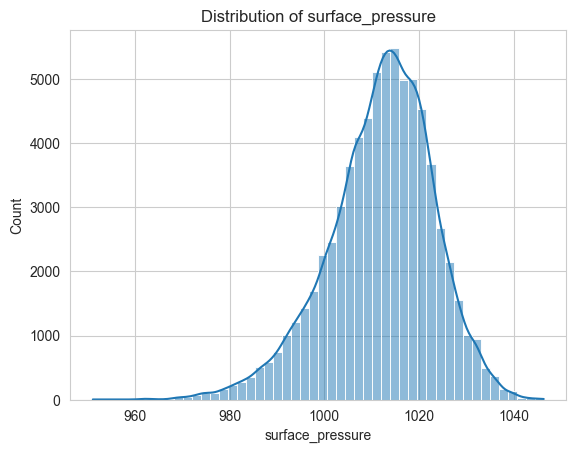

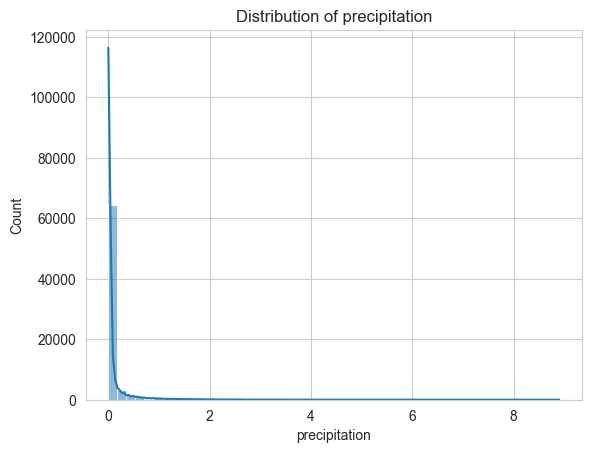

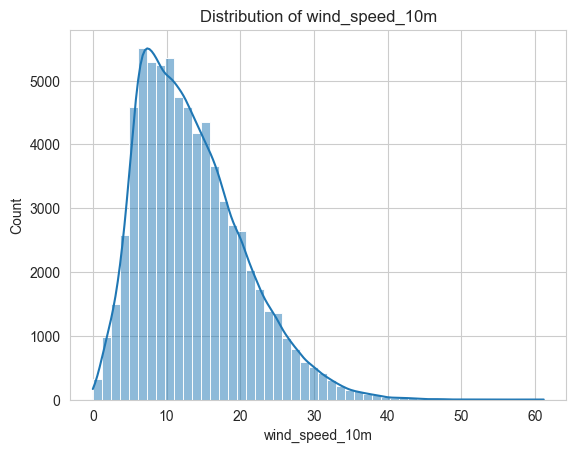

In [24]:
for col in df.columns:
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.show()

## Step 4: Seasonal and Temporal Trends
Check for monthly or seasonal patterns over time.

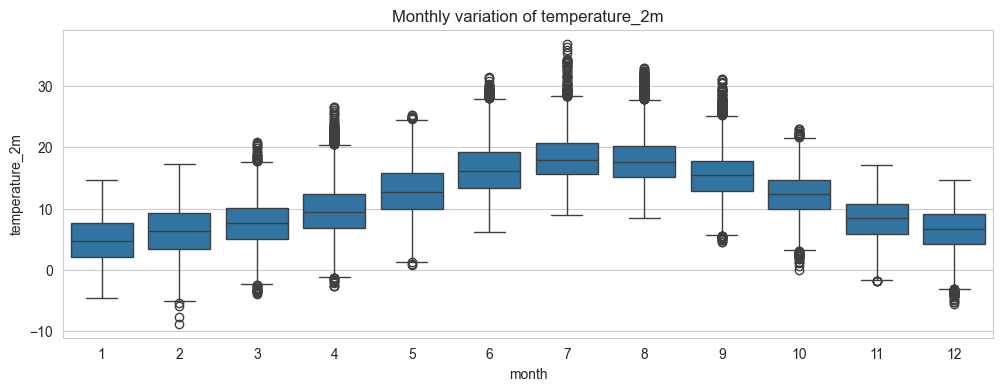

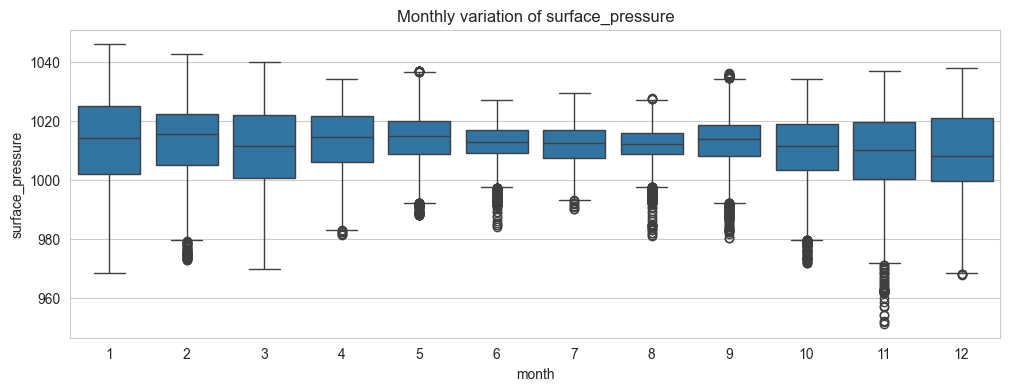

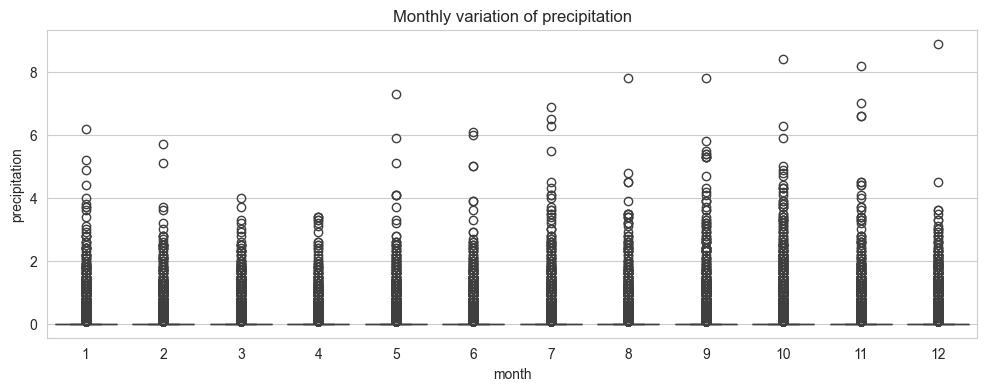

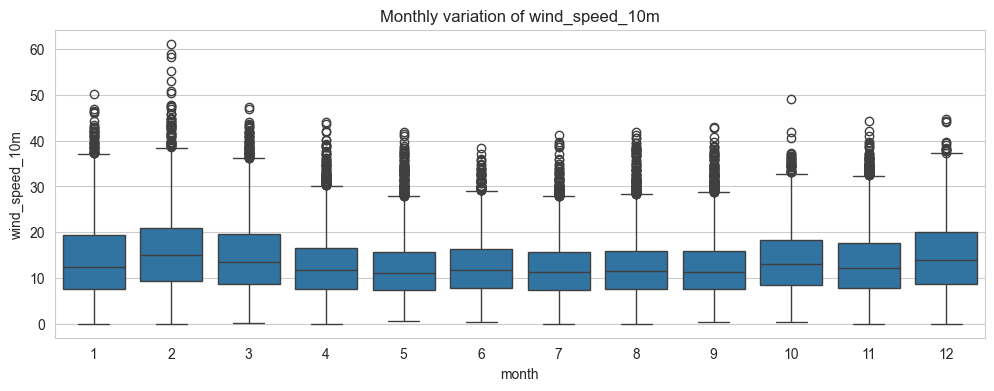

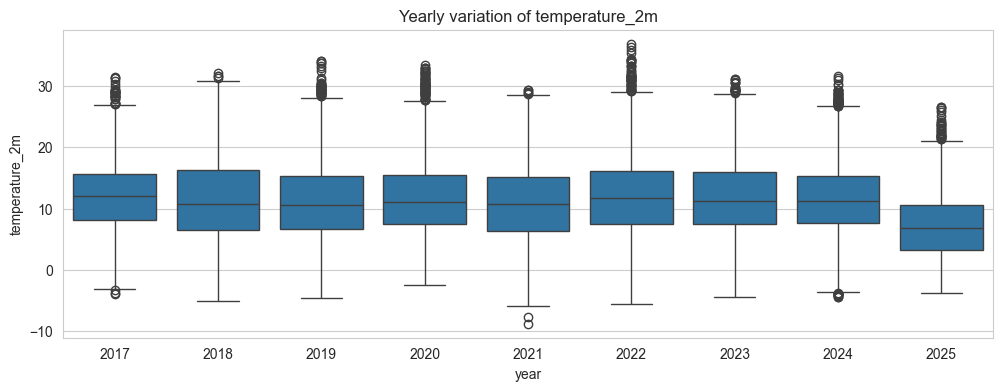

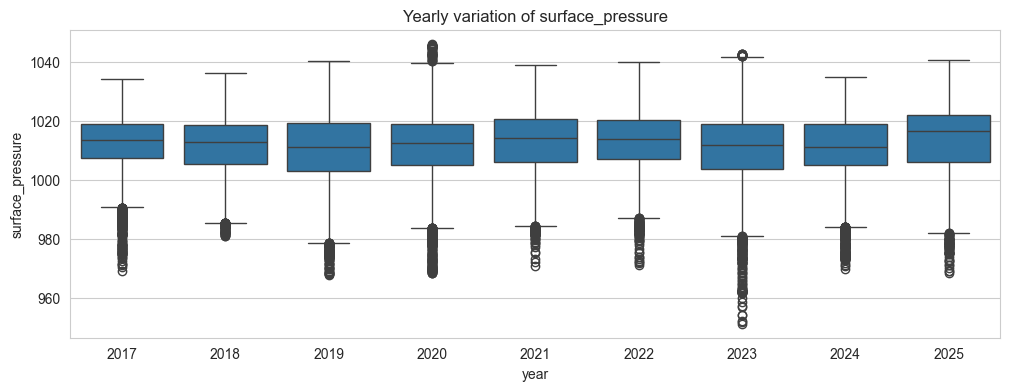

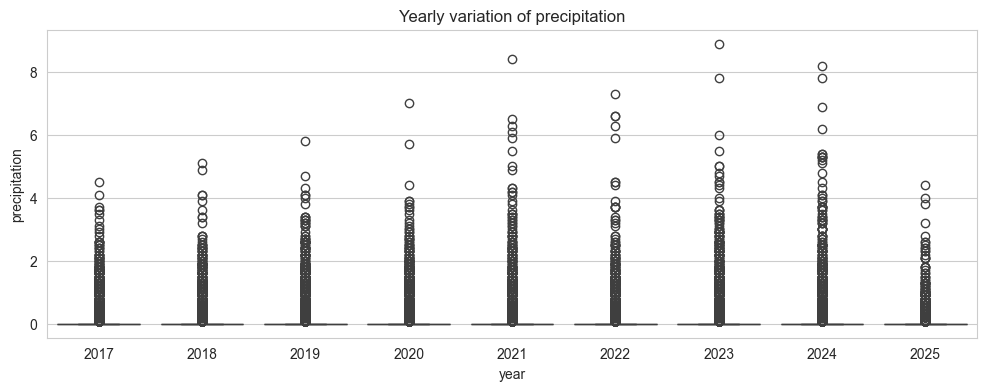

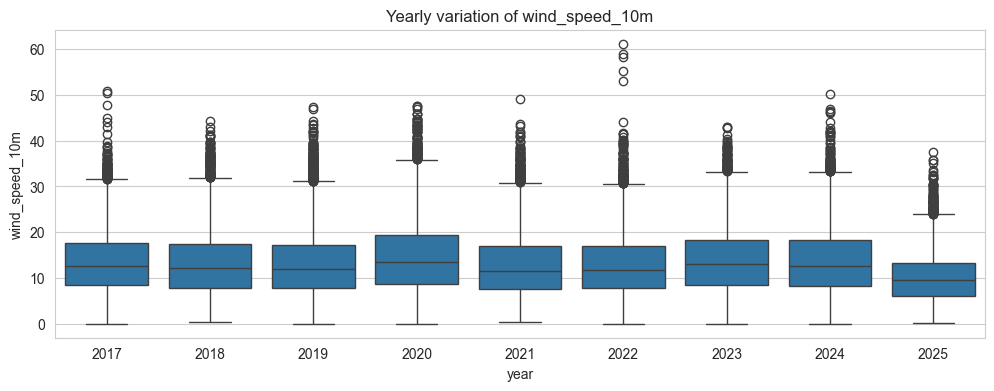

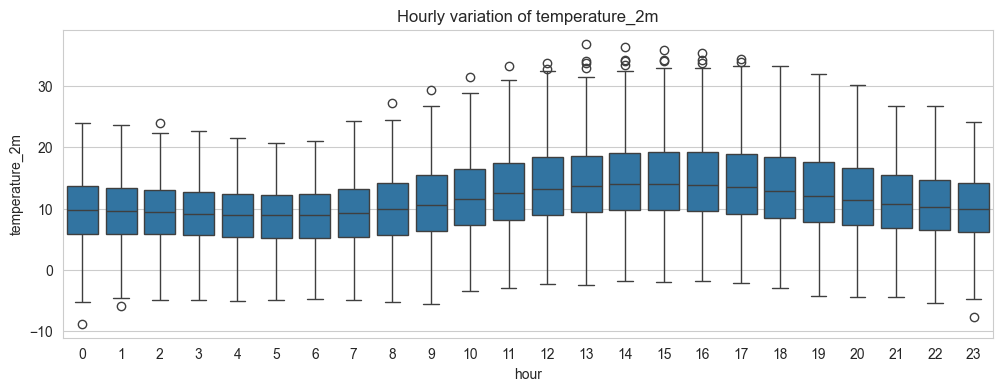

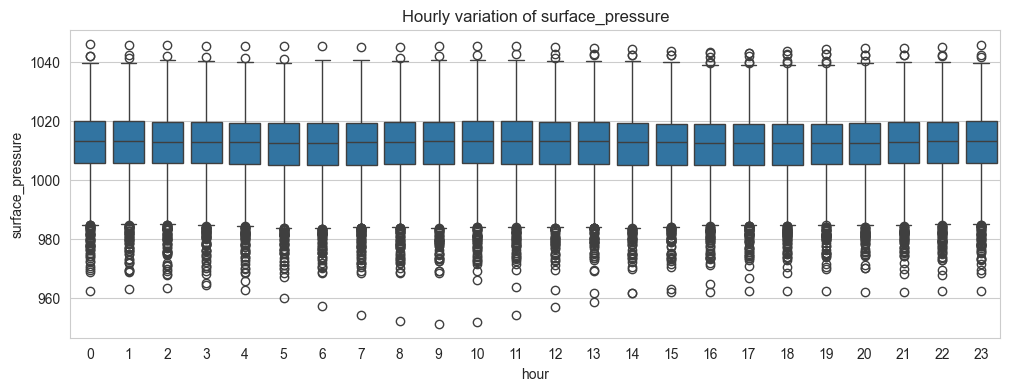

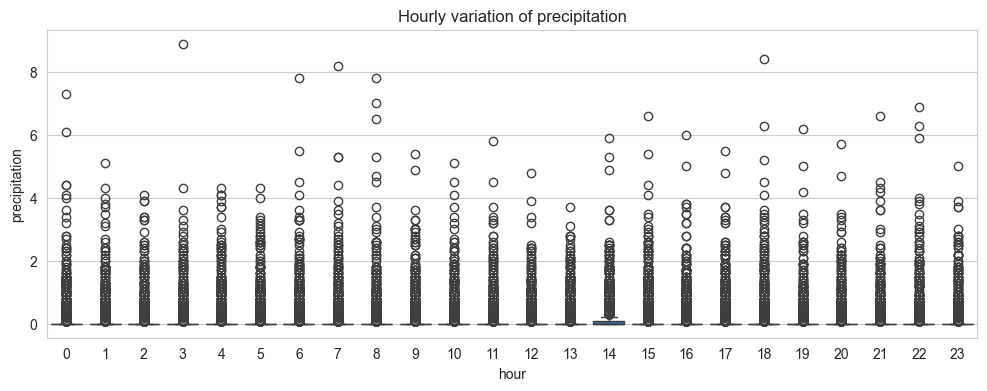

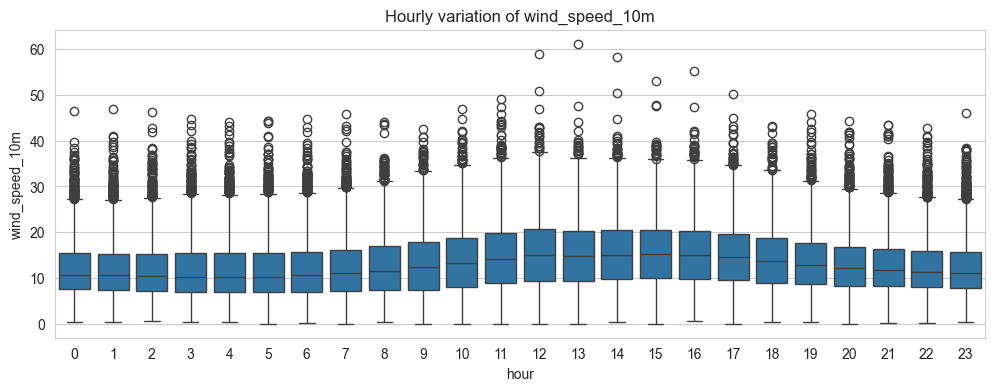

In [31]:
df['month'] = df.index.month
df['year'] = df.index.year
df['hour'] = df.index.hour

for col in ['temperature_2m', 'surface_pressure', 'precipitation', 'wind_speed_10m']:
    plt.figure(figsize=(12, 4))
    sns.boxplot(data=df, x='month', y=col)
    plt.title(f'Monthly variation of {col}')
    plt.show()

for col in ['temperature_2m', 'surface_pressure', 'precipitation', 'wind_speed_10m']:
    plt.figure(figsize=(12, 4))
    sns.boxplot(data=df, x='year', y=col)
    plt.title(f'Yearly variation of {col}')
    plt.show()

for col in ['temperature_2m', 'surface_pressure', 'precipitation', 'wind_speed_10m']:
    plt.figure(figsize=(12, 4))
    sns.boxplot(data=df, x='hour', y=col)
    plt.title(f'Hourly variation of {col}')
    plt.show()

## Step 5: Feature Correlation
Use a heatmap to show how features relate to each other.

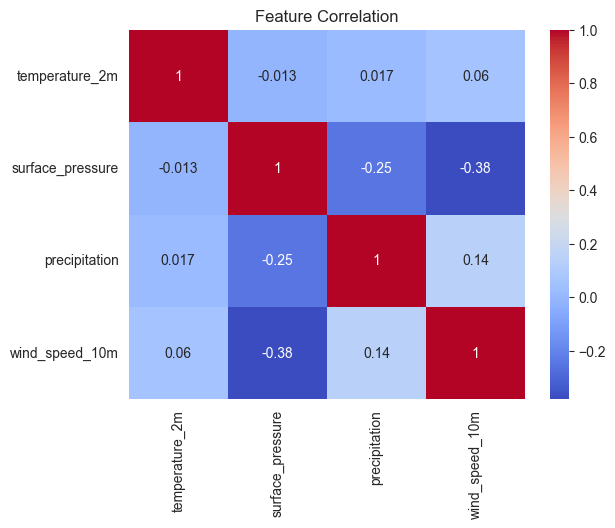

In [26]:
corr = df.drop(columns=['month', 'year']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

## Step 6: Rolling Statistics Preview
Compute 60-day rolling mean and standard deviation for visual inspection.

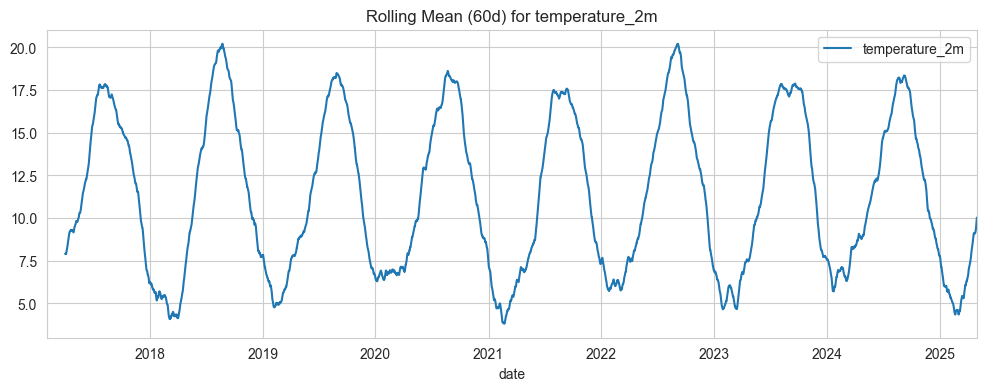

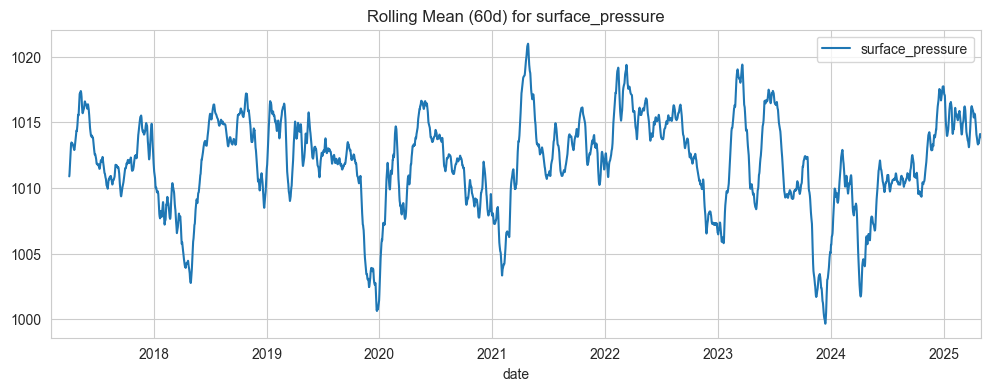

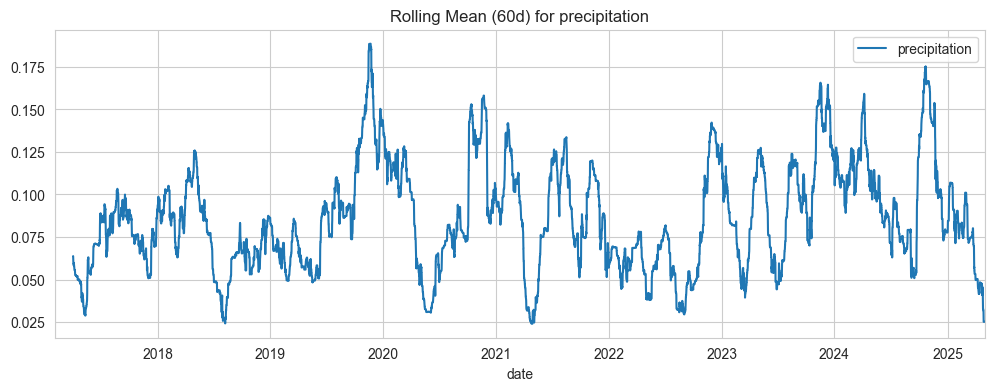

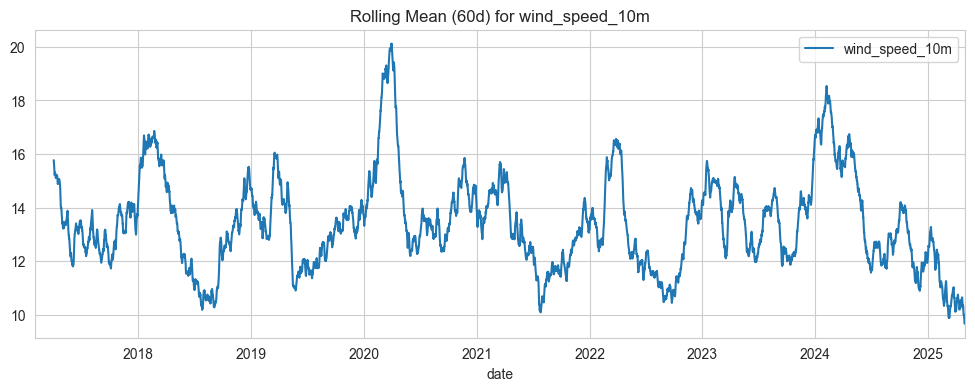

In [27]:
rolling_window = 1440  # 60 days
for col in ['temperature_2m', 'surface_pressure', 'precipitation', 'wind_speed_10m']:
    df[[col]].rolling(window=rolling_window).mean().plot(figsize=(12, 4))
    plt.title(f'Rolling Mean (60d) for {col}')
    plt.show()

## Step 7 Advanced Rollings Statistics Preview (Mean & Std Dev based)
Purpose: Visualise what’s considered normal over time for each feature
Method: Plot the actual values along with their 60-day rolling mean and ±2 standard deviation band (using a 1440-hour window)

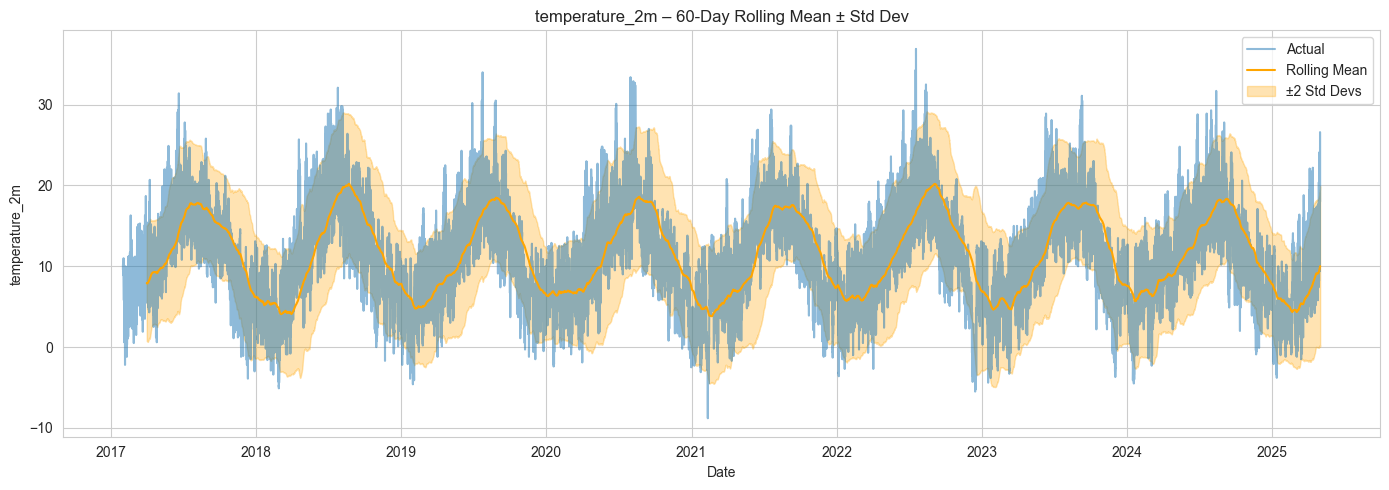

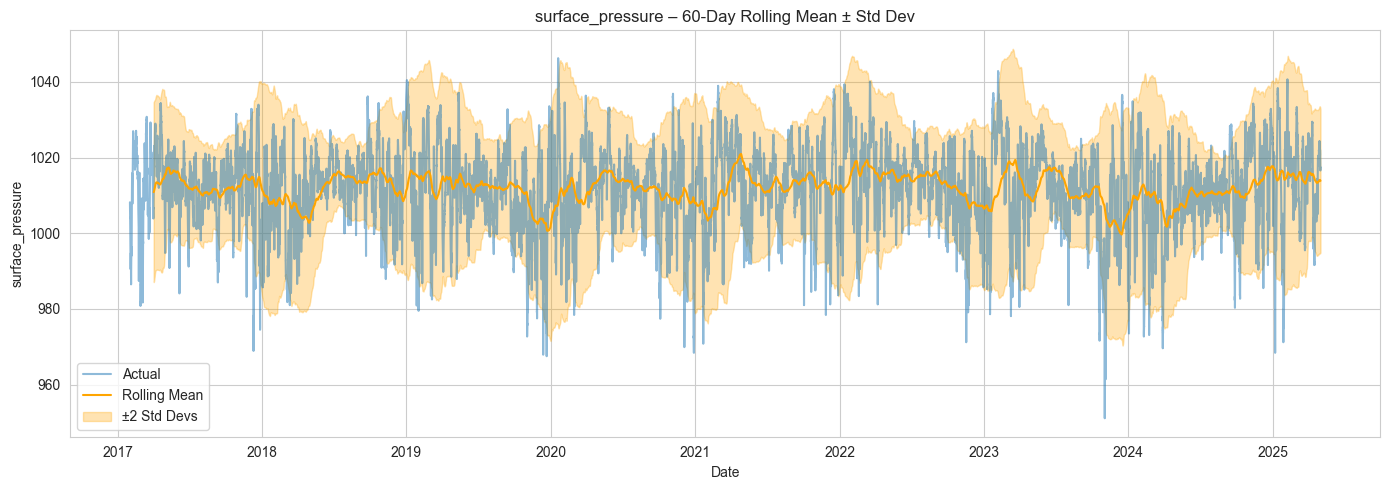

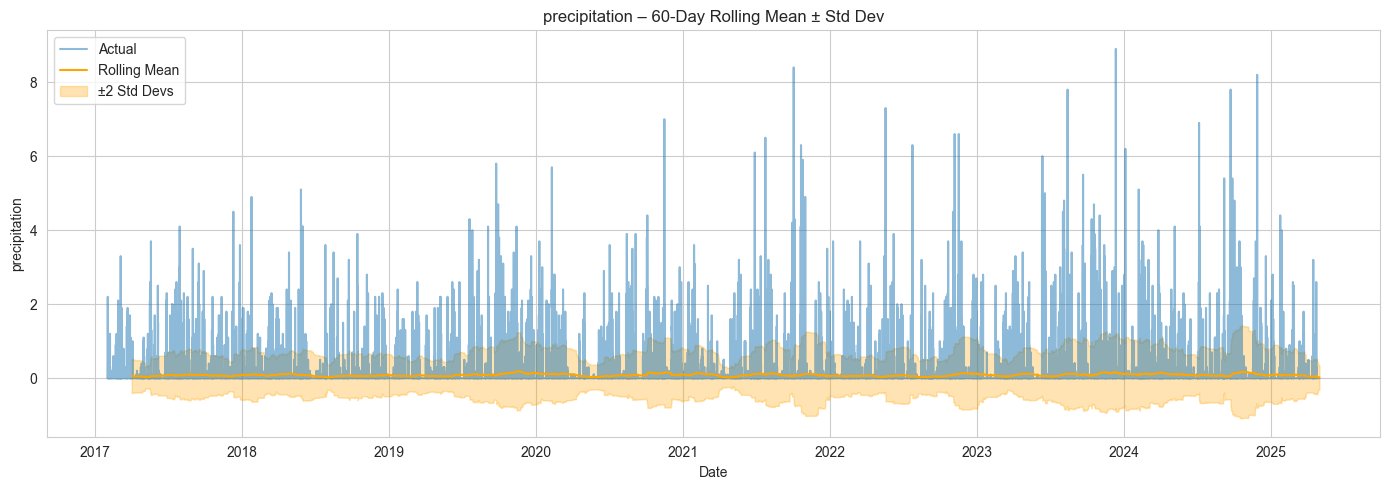

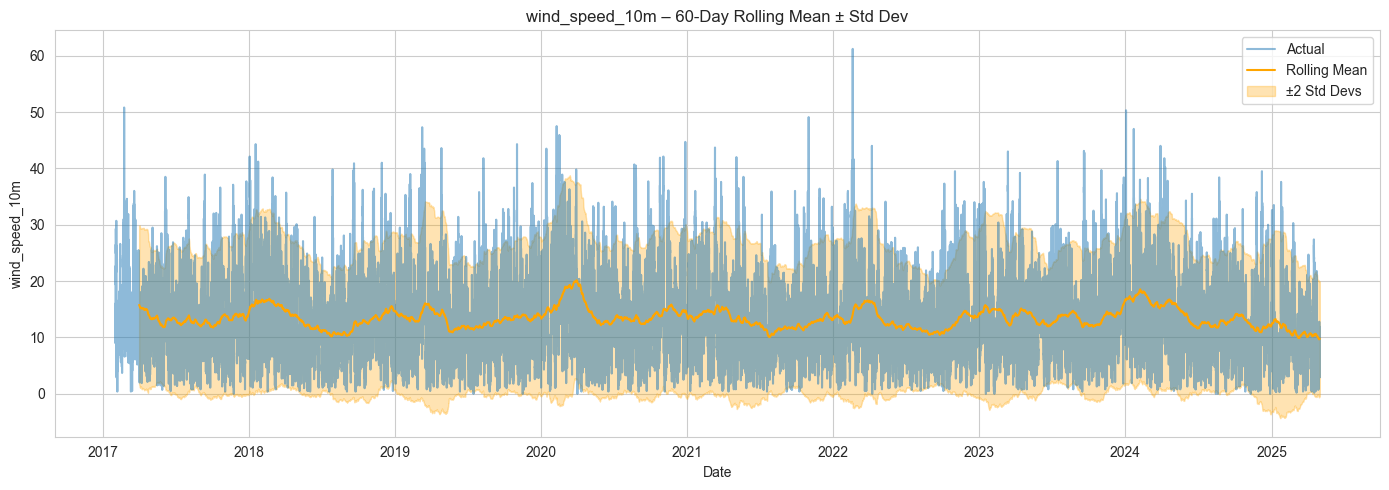

In [35]:
# Set rolling window: 60 days = 1440 hours
window = 1440

# Features to analyse
features = ['temperature_2m', 'surface_pressure', 'precipitation', 'wind_speed_10m']

# Plot rolling mean ± 1 std band for each feature
for col in features:
    rolling_mean = df[col].rolling(window=window).mean()
    rolling_std = df[col].rolling(window=window).std()

    plt.figure(figsize=(14, 5))
    plt.plot(df.index, df[col], label='Actual', alpha=0.5)
    plt.plot(df.index, rolling_mean, label='Rolling Mean', color='orange')
    plt.fill_between(
        df.index,
        rolling_mean - 2*rolling_std,
        rolling_mean + 2*rolling_std,
        color='orange',
        alpha=0.3,
        label='±2 Std Devs'
    )
    plt.title(f'{col} – 60-Day Rolling Mean ± Std Dev')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Step 7 Advanced Rollings Statistics Preview (Mean & Std Dev based)
Purpose: Visualise what’s considered normal over time for each feature
Method: Plot the actual values along with their 60-day rolling mean and ±2 standard deviation band (using a 1440-hour window)

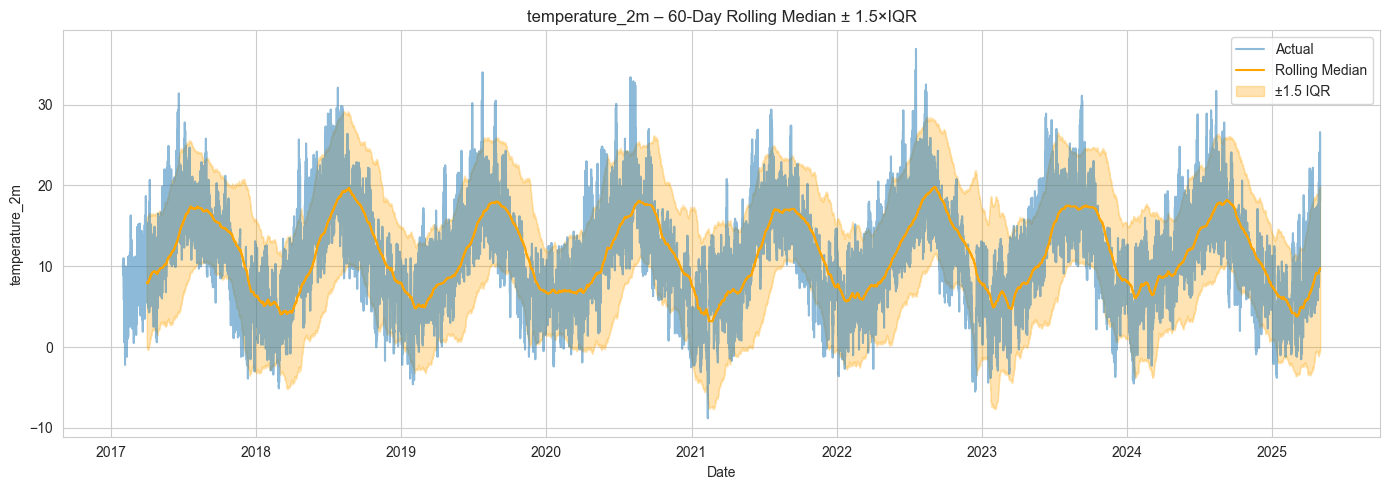

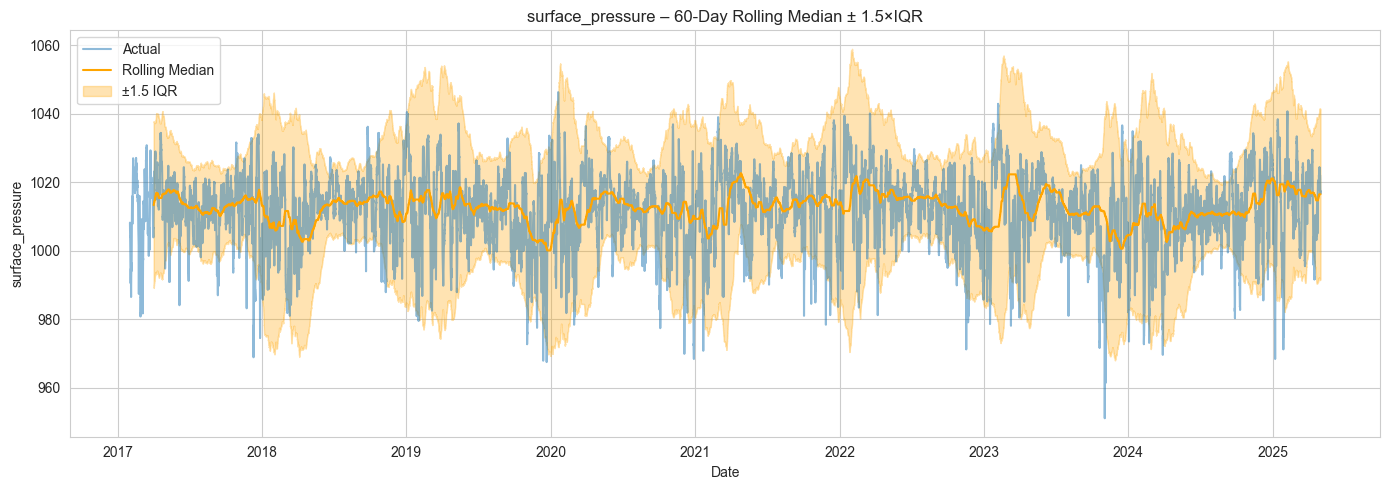

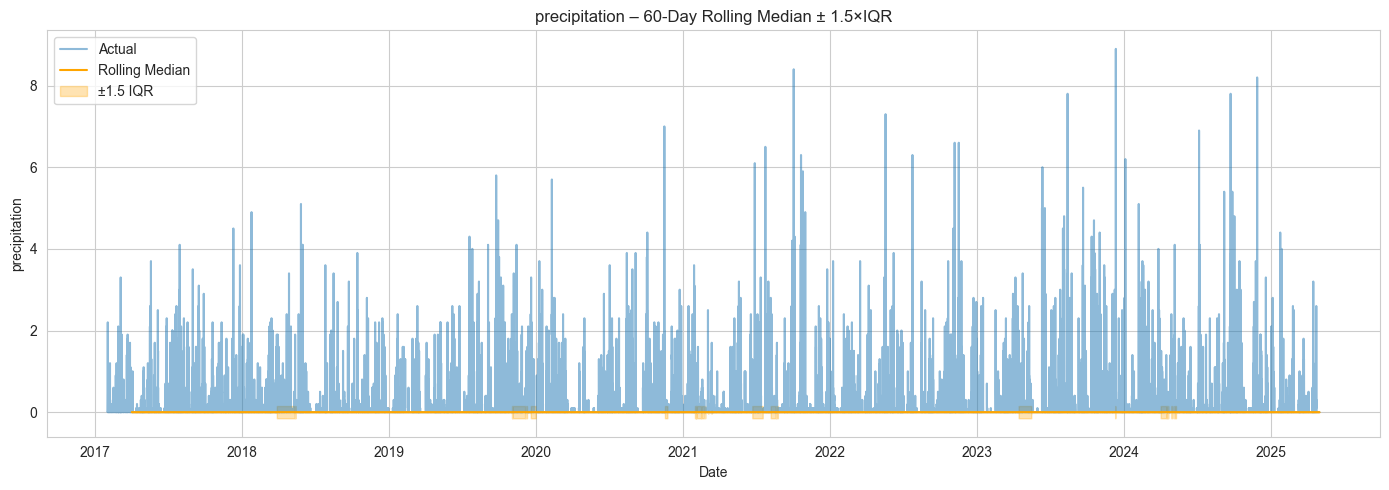

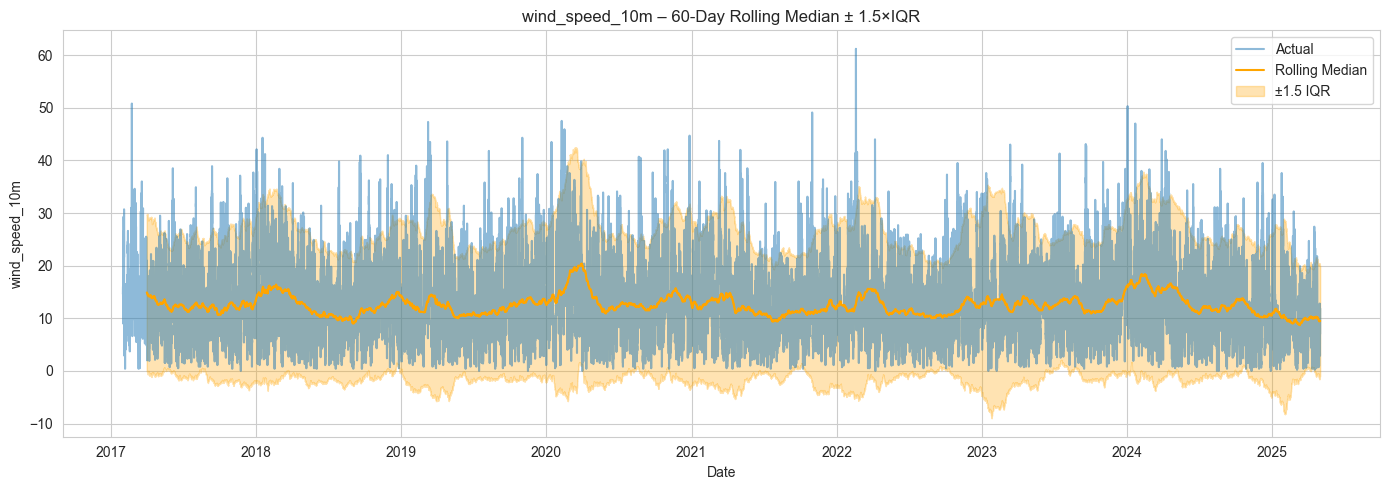

In [38]:
# Set rolling window: 60 days = 1440 hours
window = 1440

# Features to analyse
features = ['temperature_2m', 'surface_pressure', 'precipitation', 'wind_speed_10m']

# Plot rolling median ± 1.5 IQR for each feature
for col in features:
    rolling_median = df[col].rolling(window=window).median()
    rolling_q1 = df[col].rolling(window=window).quantile(0.25)
    rolling_q3 = df[col].rolling(window=window).quantile(0.75)
    rolling_iqr = rolling_q3 - rolling_q1
    lower_band = rolling_median - 1.5 * rolling_iqr
    upper_band = rolling_median + 1.5 * rolling_iqr

    plt.figure(figsize=(14, 5))
    plt.plot(df.index, df[col], label='Actual', alpha=0.5)
    plt.plot(df.index, rolling_median, label='Rolling Median', color='orange')
    plt.fill_between(
        df.index,
        lower_band,
        upper_band,
        color='orange',
        alpha=0.3,
        label='±1.5 IQR'
    )
    plt.title(f'{col} – 60-Day Rolling Median ± 1.5×IQR')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()